In [1]:
import numpy as np
import torch
import math
import torch.nn as nn
import torch.nn.functional as F

In [2]:
sequence_length = 4 # My name is XXXX
batch_size = 1
input_dim = 512 # input lenght
d_model = 512 # output of attention model / unit

In [3]:
x = torch.randn(( batch_size, sequence_length, input_dim))

In [4]:
x.size()

torch.Size([1, 4, 512])

In [5]:
qkv_layer = nn.Linear(input_dim, d_model * 3)

In [6]:
qkv = qkv_layer(x)
qkv.shape

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv distribution')

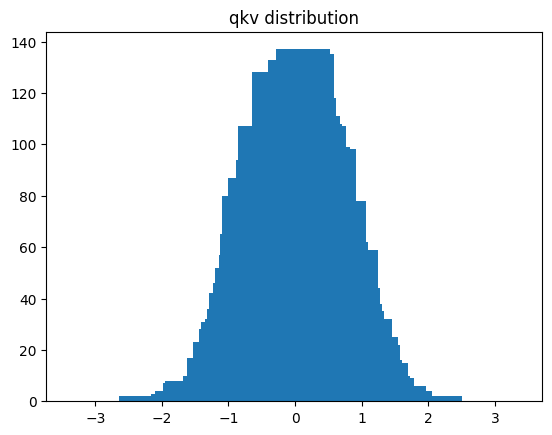

In [7]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins = 200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align="center")
plt.title('qkv distribution')

In [8]:
d_model

512

In [9]:
num_heads = 8
head_dim = d_model // num_heads # --> 512 / 8 = 64
qkv.size() # batch_size, seq_len, d_model*3 [q+k+v]

torch.Size([1, 4, 1536])

In [10]:
# batch_size, seq_len, d_model*3    -->    batch_size, seq_len, 8, 64*3
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3*head_dim)
qkv.shape

torch.Size([1, 4, 8, 192])

In [11]:
# batch_size, seq_len, 8, 3*head_dim    -->    batch_size, num_heads(3), seq_len, 3*head_dim
# 1, 4, 8, 192   -->   1, 8, 4, 192
qkv = qkv.permute(0, 2, 1, 3)
qkv.shape 

torch.Size([1, 8, 4, 192])

In [12]:
q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

# Self-Attention for Multiple Heads

In [13]:
k.T.shape

C:\Users\Tharun\AppData\Local\Temp\ipykernel_24768\3717780648.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3618.)
  k.T.shape


torch.Size([64, 4, 8, 1])

In [14]:
print("Before Self Attention Block Shape : ",k.shape)
k_new = k.transpose(-2, -1)
print("After Self Attention Block Shape  : ",k_new.shape)

Before Self Attention Block Shape :  torch.Size([1, 8, 4, 64])
After Self Attention Block Shape  :  torch.Size([1, 8, 64, 4])


In [15]:
d_k = q.shape[-1]
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [16]:
mask = torch.full(scaled.size(), float('-inf'))
mask = torch.triu(mask, diagonal=1)
mask.shape

torch.Size([1, 8, 4, 4])

In [17]:
mask[0][0], mask[0][0].shape

(tensor([[0., -inf, -inf, -inf],
         [0., 0., -inf, -inf],
         [0., 0., 0., -inf],
         [0., 0., 0., 0.]]),
 torch.Size([4, 4]))

In [18]:
(scaled + mask)[0][0]

tensor([[-0.1011,    -inf,    -inf,    -inf],
        [-0.5204, -0.1359,    -inf,    -inf],
        [ 0.1396,  0.2814, -0.5148,    -inf],
        [ 0.2761, -0.5271, -0.3291,  0.9119]], grad_fn=<SelectBackward0>)

In [19]:
scaled += mask

In [20]:
attention = F.softmax(scaled, dim=-1)

In [21]:
attention.shape

torch.Size([1, 8, 4, 4])

In [22]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.4050, 0.5950, 0.0000, 0.0000],
        [0.3742, 0.4313, 0.1945, 0.0000],
        [0.2576, 0.1154, 0.1406, 0.4864]], grad_fn=<SelectBackward0>)

In [23]:
(attention[0][0][1][0] + attention[0][0][1][1]).item() # softmax effect

1.0

# All in One Function

In [24]:
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.shape[-1]
    scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)

    if mask is not None:
        scaled += mask

    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    
    return values, attention

In [25]:
values, attention = scaled_dot_product(q, k, v, mask=mask)

In [26]:
attention.shape

torch.Size([1, 8, 4, 4])

In [27]:
values.shape

torch.Size([1, 8, 4, 64])

In [28]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.4050, 0.5950, 0.0000, 0.0000],
        [0.3742, 0.4313, 0.1945, 0.0000],
        [0.2576, 0.1154, 0.1406, 0.4864]], grad_fn=<SelectBackward0>)

In [29]:
# 1, 8, 4, 64   -->   1, 4, 8*64
values = values.reshape(batch_size, sequence_length, num_heads * head_dim)
values.shape

torch.Size([1, 4, 512])

In [30]:
linear_layer = nn.Linear(d_model, d_model)

In [31]:
out = linear_layer(values)

In [32]:
out.shape

torch.Size([1, 4, 512])

In [33]:
out

tensor([[[ 0.6245, -0.1881,  0.3920,  ..., -0.3588, -0.2870, -0.0964],
         [ 0.1910,  0.0613, -0.4628,  ...,  0.2988, -0.3282,  0.1035],
         [ 0.2392, -0.3635,  0.0556,  ...,  0.1376, -0.3445,  0.1155],
         [ 0.1123, -0.1688,  0.6475,  ...,  0.2629, -0.0961,  0.2656]]],
       grad_fn=<ViewBackward0>)

# Creating a Class

In [34]:
import torch
import torch.nn as nn
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.shape[-1]

    scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)

    return values, attention

In [35]:
class MultiHeadAttention(nn.Module):

    def __init__(self, input_dim, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads

        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim, 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask = None):

        batch_size, sequence_length, input_dim = x.shape
        print(f"x.size(): {x.size()}")

        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")

        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}")

        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")

        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")

        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")

        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")

        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        
        return out

# Input

In [36]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn( (batch_size, sequence_length, input_dim) )

model = MultiHeadAttention(input_dim, d_model, num_heads)
out = model.forward(x)

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size: torch.Size([30, 8, 5, 64]), k size: torch.Size([30, 8, 5, 64]), v size: torch.Size([30, 8, 5, 64]), 
values.size(): torch.Size([30, 8, 5, 64]), attention.size:torch.Size([30, 8, 5, 5]) 
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])
